## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [93]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

In [94]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [95]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


In [96]:
# ==============================================================================
# CELL 1.5: KHỞI TẠO VÀ QUẢN LÝ TRÍ NHỚ DÀI HẠN (NÂNG CẤP V9.4)
# ==============================================================================
MEMORY_FILE_PATH = "long_term_memory.json"
memory_vector_store = None

# Hàm để tải trí nhớ từ file JSON
def load_memory():
    if not os.path.exists(MEMORY_FILE_PATH):
        return []
    with open(MEMORY_FILE_PATH, 'r', encoding='utf-8') as f:
        return json.load(f)

# Hàm để lưu một giáo án mới vào trí nhớ
def save_to_memory(request: str, structured_plan: Dict[str, Any]):
    memory = load_memory()
    memory.append({
        "request": request,
        "plan": structured_plan
    })
    with open(MEMORY_FILE_PATH, 'w', encoding='utf-8') as f:
        json.dump(memory, f, ensure_ascii=False, indent=2)
    print_step("🧠 Đã lưu giáo án thành công vào Trí nhớ Dài hạn.")

# Hàm để tạo một vector store từ trí nhớ (để tìm kiếm tương đồng)
def build_memory_vector_store():
    global memory_vector_store
    memory_content = load_memory()
    if not memory_content:
        print_warning("Trí nhớ trống, không có gì để xây dựng vector store.")
        return

    # Chỉ lấy phần 'request' để tìm kiếm
    texts = [item['request'] for item in memory_content]
    # Lưu toàn bộ item làm metadata
    metadatas = memory_content
    
    memory_vector_store = FAISS.from_texts(texts, embeddings, metadatas=metadatas)
    print_step("✅ Đã xây dựng Vector Store cho Trí nhớ Dài hạn.")

# Tự động xây dựng vector store khi khởi động notebook
build_memory_vector_store()

⚠️  Trí nhớ trống, không có gì để xây dựng vector store.

## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [97]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [98]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    inspirational_example: Optional[List[Dict[str, Any]]]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [99]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [100]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (NÂNG CẤP V9.0)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA (giữ nguyên) ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === NÂNG CẤP V9.0: PYDANTIC MODELS MỚI CHO TƯ DUY SÂU ===

class DifferentiatedInstructionModel(BaseModel):
    """Gợi ý cụ thể cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str = Field(description="Một gợi ý hoạt động, câu hỏi, hoặc sự hỗ trợ cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Một câu hỏi mở rộng, một thử thách, hoặc một hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Thảo luận nhóm về ứng dụng của Tích phân'")
    description: str = Field(description="Mô tả chi tiết các bước HỌC SINH cần làm.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể cho học sinh.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này, ví dụ một câu hỏi phụ khó hơn.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    """Mở rộng StudentPersona để bao gồm cả chiến lược phân hóa tổng thể."""
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

# --- Các model khác giữ nguyên ---
class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn.")
    stage_objective: str = Field(description="Mô tả mục tiêu của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.


In [101]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [102]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...")
    
    inspirational_example = state.get("inspirational_example")
    example_prompt_part = ""
    if inspirational_example:
        example_prompt_part = f"""
        **VÍ DỤ THAM KHẢO (TỪ MỘT GIÁO ÁN THÀNH CÔNG TRƯỚC ĐÂY):**
        Đây là một luồng hoạt động đã được chứng minh là hiệu quả cho một chủ đề tương tự. Hãy học hỏi cấu trúc và cách tiếp cận từ nó:
        ```json
        {json.dumps(inspirational_example, ensure_ascii=False, indent=2)}
        ```
        """
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    
    {example_prompt_part}
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

async def memory_retrieval_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...")
    
    if not memory_vector_store:
        print_warning("Không có Trí nhớ Dài hạn. Bỏ qua bước này.")
        return {"inspirational_example": None}

    user_request = state["original_request"]
    
    # Tìm kiếm 1 ví dụ tương đồng nhất trong trí nhớ
    try:
        results = memory_vector_store.similarity_search_with_score(user_request, k=1)
        if results and results[0][1] < 0.5: # Chỉ lấy nếu độ tương đồng cao (điểm score thấp là tốt)
            best_example = results[0][0].metadata
            print_result(best_example['request'], "Tìm thấy ví dụ tương đồng trong trí nhớ")
            # Chỉ trả về phần "lesson_flow" để làm ví dụ
            return {"inspirational_example": best_example['plan']['lesson_flow']}
        else:
            print_step("Không tìm thấy ví dụ nào đủ tương đồng trong trí nhớ.")
            return {"inspirational_example": None}
    except Exception as e:
        print_warning(f"Lỗi khi truy xuất trí nhớ: {e}")
        return {"inspirational_example": None}
    
print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [103]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [104]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (NÂNG CẤP V9.0)
# ==============================================================================
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    reflection_notes = state.get('reflection_notes') # Lấy phản hồi từ lần trước (nếu có)

    # Xây dựng prompt động
    replan_prompt_part = ""
    if reflection_notes:
        print_warning(f"Nhận được yêu cầu làm lại kế hoạch từ Critic: {reflection_notes}")
        replan_prompt_part = f"""
        **PHẢN HỒI QUAN TRỌNG TỪ LẦN LẬP KẾ HOẠCH TRƯỚC (CẦN KHẮC PHỤC):**
        "{reflection_notes}"
        Dựa trên phản hồi này, hãy điều chỉnh lại danh sách nhiệm vụ của bạn. Có thể bạn cần tạo nhiều hoạt động hơn, hoặc phân bổ lại thời gian một cách hợp lý hơn.
        """

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Trợ lý Sư phạm**, chuyên viên thực thi kế hoạch.
    **NHIỆM VỤ:** Dựa vào **Bản thiết kế Sư phạm**, hãy **chuyển đổi** nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".

    {replan_prompt_part}

    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN CẦN TUÂN THỦ):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **BÁM SÁT KỊCH BẢN:** Mỗi giai đoạn trong bản thiết kế PHẢI được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập tương ứng.
    2.  **TẬP TRUNG NỘI DUNG:** Các nhiệm vụ phải xoay quanh chủ đề chính.
    3.  **HÀNH ĐỘNG CỤ THỂ:** Mô tả hành động học sinh sẽ làm. CẤM các từ ngữ chung chung.
    4.  **PHÂN BỔ THỜI GIAN:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút một cách hợp lý.
    5.  **TỐI ƯU HÓA:** Gộp các nhiệm vụ có mục tiêu quá giống nhau.
    
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        # Xóa các agent_outputs cũ (trừ RAG) để bắt đầu vòng lặp mới
        # Điều này rất quan trọng để tránh các hoạt động cũ bị lẫn vào vòng mới
        agent_outputs_history = state.get("agent_outputs", {})
        new_agent_outputs = {"resources": agent_outputs_history.get("resources", [])}
        
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết (lần chạy lại)")
        
        # Xóa reflection_notes cũ sau khi đã sử dụng
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        # ... (fallback giữ nguyên)
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        topic_fallback = state.get('analyzed_objective', {}).get('topic', state.get('original_request', 'chủ đề đã cho'))
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": f"Học sinh thực hành các bài tập cơ bản liên quan đến chủ đề: {topic_fallback}.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Contextual Critic` (v9.2) đang phản biện nội dung...")
    content = state.get('current_content_to_validate')
    task_list = state.get('task_list', [])
    current_task = next((t for t in task_list if t['task_id'] == state.get('current_task_id')), None)
    
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia thẩm định giáo án cực kỳ kinh nghiệm và cẩn thận.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động và đối chiếu nó với yêu cầu ban đầu.
    **YÊU CẦU GỐC CỦA NHIỆM VỤ:**
    - Tên nhiệm vụ: "{current_task.get('task_name', 'N/A')}"
    - Mô tả: "{current_task.get('task_description', 'N/A')}"
    - Thời lượng dự kiến: "{current_task.get('estimated_duration', 'N/A')} phút"

    **NỘI DUNG ĐƯỢC TẠO RA CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```

    **TIÊU CHÍ PHẢN BIỆN (THEO THỨ TỰ ƯU TIÊN):**
    1.  **Lỗi Cấu trúc hoặc Thời gian (Rất quan trọng):** Nội dung được tạo có mâu thuẫn với yêu cầu gốc không? Đặc biệt, thời lượng `duration_minutes` có hợp lý với các bước được mô tả trong `description` không? Nếu có mâu thuẫn lớn (ví dụ: mô tả một hoạt động 20 phút nhưng `duration_minutes` chỉ là 5), đây là LỖI CẤU TRÚC.
    2.  **Tính chính xác chuyên môn:** Nội dung có sai sót về kiến thức không?
    3.  **Tính phù hợp sư phạm:** Nội dung có phù hợp với lứa tuổi và đặc điểm lớp học không?

    **YÊU CẦU ĐỊNH DẠNG:**
    - Nếu nội dung hợp lệ, trả về JSON với `is_valid: true` và `feedback` là "Nội dung hợp lệ.".
    - Nếu có lỗi về chuyên môn hoặc sư phạm (lỗi có thể sửa bằng cách viết lại nội dung), trả về `is_valid: false` và `feedback` mô tả lỗi đó.
    - **NẾU CÓ LỖI CẤU TRÚC HOẶC THỜI GIAN**, trả về `is_valid: false` và bắt đầu `feedback` bằng từ khóa **`[STRUCTURAL_FEEDBACK]`**. Ví dụ: `[STRUCTURAL_FEEDBACK] Thời lượng 5 phút là bất khả thi cho hoạt động được mô tả, cần ít nhất 15 phút.`
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if not result.is_valid:
            print_warning(f"PHẢN BIỆN: {result.feedback}")
            return {"validation_feedback": result.feedback, "current_content_to_validate": content}
        else:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

print("✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.")


# === NÂNG CẤP: Logic của agent chuyên môn giờ đây phải suy nghĩ về phân hóa ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    # Lấy chiến lược phân hóa tổng thể từ state
    differentiation_strategy = state.get('student_persona', {}).get('differentiation_strategy', {})

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và chu đáo.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT**, có tính đến sự đa dạng của học sinh trong lớp.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung của bài:** {json.dumps(differentiation_strategy, ensure_ascii=False)}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán, các bước thực hành rõ ràng.
    2.  **MÔ TẢ HÀNH ĐỘNG CỦA GIÁO VIÊN:** Liệt kê các hành động cụ thể.
    3.  **SUY NGHĨ VỀ PHÂN HÓA (RẤT QUAN TRỌNG):** Dựa vào "Chiến lược phân hóa chung", hãy tạo ra các gợi ý phân hóa (`differentiation`) **cụ thể cho hoạt động này**. Ví dụ: Nếu chiến lược chung là "cung cấp gợi ý", thì gợi ý cụ thể ở đây là gì?
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (có phân hóa)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}


async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.4 - Hỗ trợ Phân hóa và Lập kế hoạch lại) đã sẵn sàng.")

✅ Agent phản biện nội dung 'content_validator_agent' (v9.2 - Hỗ trợ Leo thang) đã được định nghĩa.
✅ Các agent giao việc và chuyên môn (v9.4 - Hỗ trợ Phân hóa và Lập kế hoạch lại) đã sẵn sàng.


In [105]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP CÓ CẤU TRÚC & NODE TRÌNH BÀY (NÂNG CẤP V9.0)
# ==============================================================================
# Nâng cấp 1: Agent này giờ chỉ tạo đối tượng JSON có cấu trúc
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    # Kiểm tra điều kiện hợp lệ (giữ nguyên)
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not all_content_items or not ((allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc số lượng hoạt động quá ít. Lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...")
    
    # Tổ chức dữ liệu từ state
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = {
        "chủ đề": objective.get('topic', 'N/A'),
        "môn học": state.get('domain', 'N/A'),
        "lớp": objective.get('grade_level', 'N/A'),
        "thời lượng": f"{allowed_duration} phút",
        "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'),
        "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'),
    }

    learning_objectives = [
        f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.",
        "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.",
        "Phát triển kỹ năng hợp tác và trình bày."
    ]

    preparation = {
        "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập (nếu có trong hoạt động)"],
        "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"]
    }
    
    # Sắp xếp các hoạt động
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Xây dựng đối tượng JSON cuối cùng theo schema FinalStructuredPlan
    final_plan_obj: FinalStructuredPlan = {
        "general_info": general_info,
        "learning_objectives": learning_objectives,
        "preparation": preparation,
        "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'),
        "lesson_flow": all_content_sorted,
    }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# Nâng cấp 2: Thêm Node mới chỉ để tạo Markdown từ JSON
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...")
    
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict):
        return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án có cấu trúc để tạo Markdown."}

    # Dùng Python f-string để "dịch" JSON thành Markdown
    md_parts = []
    
    # Phần I: Thông tin chung
    info = plan_json['general_info']
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items():
        md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json['learning_objectives']:
        md_parts.append(f"- {obj}")

    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json['preparation'].items():
        md_parts.append(f"- **{key.title()}:** {', '.join(items)}")


    # === SỬA ĐỔI FORMAT Ở ĐÂY ===
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json['lesson_flow']):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        
        description_key = 'question' if 'question' in activity else 'description'
        md_parts.append(f"**Nhiệm vụ:**\n{activity.get(description_key)}")
        
        if activity.get('differentiation'):
            diff = activity['differentiation']
            # Sử dụng cú pháp blockquote (>) để thụt đầu dòng và làm nổi bật
            md_parts.append(f"> **Gợi ý Phân hóa:**")
            md_parts.append(f"> - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"> - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
        
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json['knowledge_summary'])

    final_md = "\n".join(md_parts)
    
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.")


✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [106]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

def save_to_memory_node(state: "TeacherStateV5"):
    print_step("Kiểm tra để lưu vào Trí nhớ Dài hạn...")
    if state.get("final_structured_plan"):
        save_to_memory(state["original_request"], state["final_structured_plan"])
    return {} 

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [107]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry"]:
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để thử lại.")
        return "retry"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: return "compile_and_critique"
    else: return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"



print("✅ Các hàm logic điều hướng đã được định nghĩa.")

✅ Các hàm logic điều hướng đã được định nghĩa.


In [108]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (NÂNG CẤP V9.5 - SỬA LỖI CONCURRENT UPDATE)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# 1. Thêm các node vào graph (giữ nguyên)
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("save_to_memory", save_to_memory_node) # Giữ lại node này
workflow.add_node("delay_node", delay_node)


# 2. Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "memory_retrieval")
workflow.add_edge("memory_retrieval", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# --- LUỒNG THỰC THI NHIỆM VỤ ---
# Router quyết định đi đâu
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler"
    }
)
# Dispatcher quyết định giao cho ai
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})

# Các specialist agent đều đi đến Validator
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")

# === SỬA LỖI Ở ĐÂY: Logic điều hướng sau khi Validate ===
# Validator quyết định commit, thử lại, hay quy hoạch lại
workflow.add_conditional_edges(
    "content_validator", 
    route_after_validation, 
    {
        "commit": "commit_validated_content", 
        "retry_content": "task_dispatcher", # Lỗi nội dung -> Quay lại Dispatcher để thử lại
        "replan_task": "plan_delegator" # Lỗi cấu trúc -> Quay lại Delegator để quy hoạch lại
    }
)

# Sau khi commit, đánh dấu hoàn thành và quay lại Router
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")


# --- LUỒNG KẾT THÚC ---
# Logic điều hướng sau khi biên dịch JSON
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_structured_compilation,
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter"
    }
)
# Sau khi tạo markdown, lưu vào trí nhớ rồi kết thúc
workflow.add_edge("markdown_presenter", "save_to_memory")
workflow.add_edge("save_to_memory", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph 9.5 (The Self-Correcting Co-Pilot - Concurrent Update Fixed) đã được biên dịch thành công.")

ValueError: Found edge starting at unknown node 'memory_retrieval'

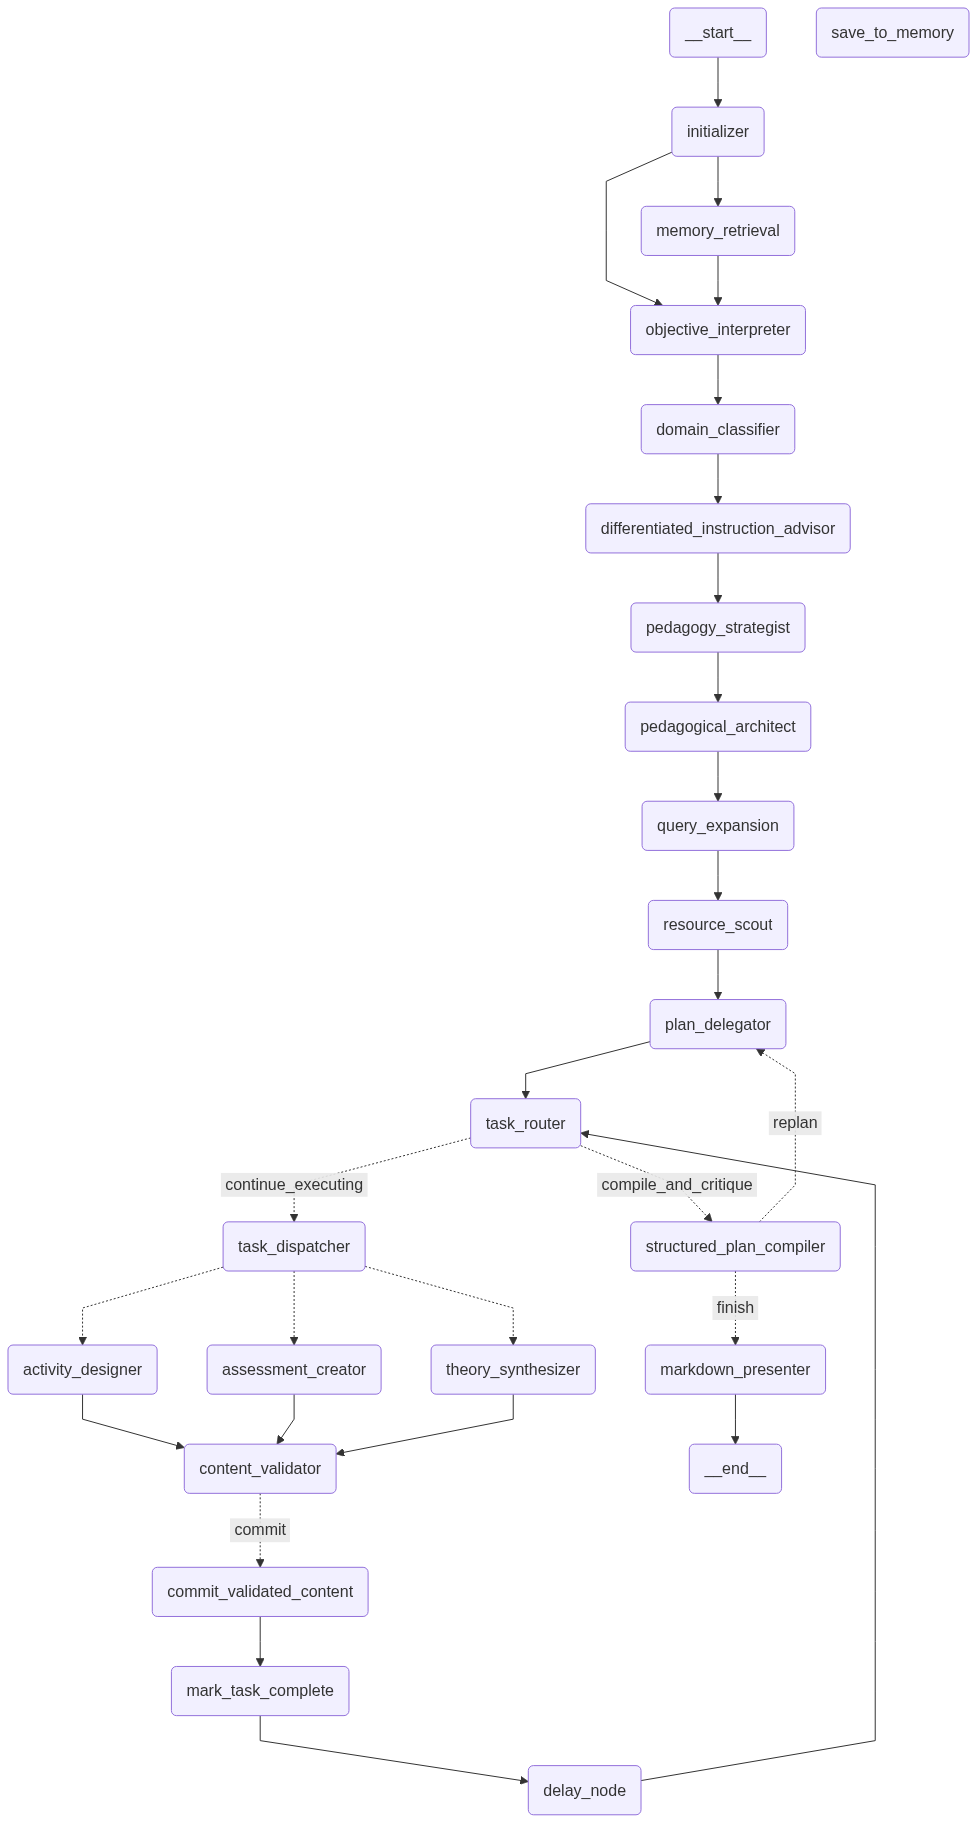

In [ ]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [ ]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [ ]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Memory Retrieval` (v9.4) đang tìm kiếm trong trí nhớ...

⚠️  Không có Trí nhớ Dài hạn. Bỏ qua bước này.

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

------- Hoàn thành bước: memory_retrieval -------

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 3,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu, học sinh dễ mất tập trung, cần các hoạt động tương tác cao để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ trực quan và hình ảnh minh họa. Cung cấp phiếu bài tập có sẵn công thức, gợi ý từng bước giải. Tăng cường hoạt động nhóm đôi, nhóm nhỏ để học sinh yếu có cơ hội trao đổi và nhận hỗ trợ từ bạn bè. Thường xuyên kiểm tra nhanh sự hiểu bài bằng các câu hỏi trắc nghiệm đơn giản hoặc giơ tay.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao hơn, yêu cầu chứng minh hoặc giải thích sâu hơn về các tính chất. Khuyến khích học sinh khá giỏi tìm kiếm các ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp trong kiến trúc, kỹ thuật. Giao nhiệm vụ hỗ trợ, hướng dẫn các bạn trong nhóm khi cần thiết, hoặc chuẩn bị một câu hỏi mở rộng để đặt ra cho cả lớp.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu, học sinh dễ mất tập trung, cần các hoạt động tương tác cao để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ trực quan và hình ảnh minh họa. Cung cấp phiếu bài tập có gợi ý từng bước hoặc các bài tập điền khuyết. Tăng cường hoạt động nhóm nhỏ để học sinh yếu có thể nhận được sự hỗ trợ từ bạn bè và giáo viên. Thường xuyên kiểm tra nhanh sự hiểu bài bằng các câu hỏi đơn giản.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao có tính ứng dụng thực tế hoặc yêu cầu chứng minh các tính chất mở rộng của đường tròn. Khuyến khích học sinh khá giỏi tự tìm hiểu thêm về các khái niệm liên quan hoặc chuẩn bị một phần trình bày ngắn gọn về một ứng dụng của đường tròn trong đời sống/kỹ thuật.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp dạy học hợp tác rất phù hợp với đặc điểm lớp học này vì: Học sinh yếu và dễ mất tập trung sẽ được khuyến khích tương tác liên tục với bạn bè trong nhóm, giúp duy trì sự chú ý và hứng thú. Học sinh khá giỏi có cơ hội hỗ trợ, giải thích cho các bạn yếu hơn, từ đó củng cố kiến thức của chính mình. Việc chia nhỏ nhiệm vụ và làm việc nhóm giúp giảm áp lực cho từng cá nhân, đồng thời tạo môi trường an toàn để học sinh yếu mạnh dạn trao đổi. Phương pháp này cũng dễ dàng tích hợp các chiến lược phân hóa đã đề ra, đảm bảo mọi học sinh đều có thể tiếp cận và vận dụng kiến thức về đường tròn ngoại tiếp và nội tiếp.',
│   'key_actions': [
│   │   'Chia nhóm và giới thiệu nhiệm vụ học tập',
│   │   'Học sinh làm việc nhóm, thảo luận và giải quyết các nhiệm vụ được giao',
│   │   'Giáo viên quan sát, hỗ trợ, gợi ý và giải đáp thắc mắc cho từng nhóm',
│   │   'Đại diện nhóm trình bày kết quả hoặc cách giải quyết vấn đề',
│   │   'Giáo viên và cả lớp cùng thảo luận, tổng kết kiến thức và củng cố bài học'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp Dạy học hợp tác rất phù hợp với lớp học có tốc độ học chậm, dễ mất tập trung và có xu hướng thụ động. Việc chia nhóm học sinh hỗn hợp (có cả học sinh yếu và khá) sẽ khuyến khích sự tương tác, hỗ trợ lẫn nhau, giúp học sinh yếu không bị bỏ lại phía sau và học sinh khá giỏi có cơ hội củng cố kiến thức bằng cách hướng dẫn bạn. Các hoạt động nhóm liên tục sẽ duy trì sự chú ý, giảm thiểu tình trạng mất tập trung. Giáo viên có thể dễ dàng quan sát, hỗ trợ từng nhóm, từng cá nhân, đồng thời áp dụng các chiến lược phân hóa đã đề ra (chia nhỏ kiến thức, cung cấp gợi ý, giao bài tập nâng cao) một cách hiệu quả trong môi trường nhóm.',
│   'key_actions': [
│   │   'Tổ chức nhóm học tập hỗn hợp (có sự phân hóa về năng lực).',
│   │   'Giao nhiệm vụ khám phá và giải quyết vấn đề theo nhóm, sử dụng phiếu học tập có gợi ý và hình ảnh trực quan.',
│   │   'Học sinh thảo luận, hợp tác giải quyết nhiệm vụ dưới sự hướng dẫn và hỗ trợ cá nhân hóa của giáo viên.',
│   │   'Đại diện nhóm trình bày kết quả, chia sẻ cách làm và nhận phản hồi từ giáo viên, bạn bè.',
│   │   'Giáo viên tổng kết, củng cố kiến thức trọng tâm và giao bài tập nâng cao/ứng dụng cho học sinh khá giỏi.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   "Khởi động và Khám phá ban đầu: Giáo viên tổ chức hoạt động 'Đố vui hình học' hoặc 'Ghép hình' để ôn tập kiến thức cũ về đường tròn và tam giác. Sau đó, sử dụng hình ảnh/video trực quan để giới thiệu các trường hợp đường tròn đi qua các đỉnh của tam giác hoặc tiếp xúc với các cạnh của tam giác, đặt câu hỏi gợi mở để học sinh tự đặt vấn đề về mối quan hệ này.",
│   'Xây dựng kiến thức mới: Chia lớp thành các nhóm nhỏ (4-5 học sinh). Mỗi nhóm nhận một phiếu học tập có các hoạt động khám phá (ví dụ: vẽ hình, cắt dán, đo đạc) để tự rút ra định nghĩa và cách xác định tâm, bán kính của đường tròn ngoại tiếp và nội tiếp. Giáo viên di chuyển giữa các nhóm để quan sát, gợi ý và hỗ trợ kịp thời, đặc biệt chú ý đến các nhóm yếu bằng cách cung cấp gợi ý từng bước.',
│   'Luyện tập và Vận dụng: Các nhóm tiếp tục làm việc với bộ bài tập được phân hóa. Bài tập cơ bản tập trung vào nhận dạng và tính toán đơn giản, có gợi ý cho học sinh yếu. Bài tập nâng cao yêu cầu chứng minh hoặc áp dụng vào các tình huống phức tạp hơn, khuyến khích học sinh khá giỏi tự tìm tòi và trình bày cách giải.',
│   'Trình bày và Tổng kết: Mời đại diện một số nhóm lên bảng trình bày kết quả hoặc cách giải một bài tập tiêu biểu. Giáo viên tổ chức cho cả lớp nhận xét, bổ sung. Sau đó, giáo viên tổng kết lại các kiến thức trọng tâm về đường tròn ngoại tiếp và nội tiếp, nhấn mạnh các điểm cần lưu ý và giải đáp thắc mắc cuối cùng. Giao bài tập về nhà và định hướng cho buổi học tiếp theo.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Pedagogical Architect` (v9.4) đang thiết kế kịch bản buổi học...

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp là gì',
│   'đường tròn nội tiếp là gì',
│   'công thức tính bán kính đường tròn ngoại tiếp',
│   'công thức tính bán kính đường tròn nội tiếp',
│   'tính chất đường tròn ngoại tiếp tam giác',
│   'tính chất đường tròn nội tiếp tứ giác',
│   'bài tập đường tròn ngoại tiếp lớp 9',
│   'chuyên đề đường tròn nội tiếp và ngoại tiếp',
│   'cách xác định tâm đường tròn ngoại tiếp',
│   'cách vẽ đường tròn nội tiếp tam giác',
│   'ứng dụng đường tròn ngoại tiếp trong hình học',
│   'lý thuyết đường tròn nội tiếp và ngoại tiếp',
│   'đường tròn ngoại tiếp đa giác đều',
│   'đường tròn nội tiếp hình vuông',
│   'quan hệ giữa đường tròn nội tiếp và ngoại tiếp'
]

------- Hoàn thành bước: query_expansion -------

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   'Giai đoạn 1: Khởi động và Khám phá ban đầu: Giáo viên sử dụng hình ảnh/video/câu hỏi gợi mở để ôn tập kiến thức cũ về đường tròn và tam giác. Dẫn dắt vào bài mới bằng cách đặt vấn đề thực tế hoặc hình vẽ minh họa đơn giản về đường tròn ngoại tiếp/nội tiếp. Tổ chức lớp thành các nhóm học tập hỗn hợp.',
│   'Giai đoạn 2: Xây dựng kiến thức cốt lõi: Các nhóm nhận phiếu học tập có các hoạt động khám phá (ví dụ: vẽ hình, cắt dán, đo đạc, nhận xét) để tự rút ra định nghĩa và tính chất của đường tròn ngoại tiếp (tâm là giao điểm 3 đường trung trực) và đường tròn nội tiếp (tâm là giao điểm 3 đường phân giác). Giáo viên di chuyển giữa các nhóm, quan sát, gợi ý, hỗ trợ cá nhân hóa và kiểm tra nhanh sự hiểu bài.',
│   'Giai đoạn 3: Vận dụng và Củng cố: Các nhóm tiếp tục làm việc với các bài tập vận dụng trên phiếu học tập, bao gồm các bài tập nhận dạng, vẽ hình, tính toán đơn giản liên quan đến đường tròn ngoại tiếp/nội tiếp. Đại diện một số nhóm trình bày kết quả và cách làm. Giáo viên tổng kết, sửa lỗi, nhấn mạnh các kiến thức trọng tâm và các lỗi thường gặp.',
│   'Giai đoạn 4: Mở rộng và Giao nhiệm vụ: Giáo viên giao các bài tập về nhà, bao gồm cả bài tập cơ bản cho tất cả học sinh và bài tập nâng cao (có tính ứng dụng hoặc yêu cầu chứng minh) cho học sinh khá giỏi. Gợi ý các nguồn tài liệu để học sinh tự tìm hiểu thêm về ứng dụng của đường tròn trong thực tế.'
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 75 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'công thức đường tròn nội tiếp tam giác',
│   'tính bán kính đường tròn ngoại tiếp',
│   'tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp và nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp tam giác',
│   'lý thuyết đường tròn nội tiếp tam giác',
│   'tâm đường tròn ngoại tiếp là gì',
│   'tâm đường tròn nội tiếp là gì',
│   'ứng dụng đường tròn ngoại tiếp nội tiếp',
│   'phương pháp giải bài tập đường tròn ngoại tiếp',
│   'phương pháp giải bài tập đường tròn nội tiếp',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'đường tròn ngoại tiếp tứ giác',
│   'bài toán đường tròn ngoại tiếp và nội tiếp nâng cao',
│   'sách giáo khoa đường tròn ngoại tiếp nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào em,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, thầy đã đọc kỹ các đoạn văn bản em cung cấp. Dựa trên **chỉ** những thông tin có trong các đoạn văn bản này, thầy xin tổng hợp lại kiến thức cốt lõi về đường tròn và các mối quan hệ của chúng. Em lưu ý rằng, các khái niệm "đường tròn ngoại tiếp" và "đường tròn nội tiếp" không được định nghĩa trực tiếp trong các đoạn văn bản này, nhưng các kiến thức về vị trí tương đối và tiếp tuyến là rất quan trọng.\n\nDưới đây là bản tóm tắt kiến thức cốt lõi:\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ ĐƯỜNG TRÒN VÀ VỊ TRÍ TƯƠNG ĐỐI**\n\n**1. Vị trí tương đối của đường thẳng và đường tròn**\n\n*   **1.1. Định nghĩa:**\n    *   **Cắt nhau:** Đường thẳng và đường tròn có đúng hai điểm chung.\n    *   **Tiếp xúc với nhau:** Đường thẳng và đường tròn có đúng một điểm chung. Điểm chung này gọi là **tiếp điểm**. Khi đó, đường thẳng còn được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm đó.\n    *   **Không giao nhau:** Đường thẳng và đường tròn không có điểm chung nào.\n\n*   **1.2. Dấu hiệu nhận biết (qua khoảng cách từ tâm đến đường thẳng):**\n    Cho đường tròn (O; R) và đường thẳng a. Gọi d là khoảng cách từ tâm O đến đường thẳng a.\n    *   Đường thẳng a và đường tròn (O; R) **cắt nhau** khi $d < R$.\n    *   Đường thẳng a và đường tròn (O; R) **tiếp xúc với nhau** khi $d = R$.\n    *   Đường thẳng a và đường tròn (O; R) **không giao nhau** khi $d > R$.\n\n**2. Dấu hiệu nhận biết tiếp tuyến của đường tròn**\n\n*   **Định lí 1:** Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó thì đường thẳng ấy là một tiếp tuyến của đường tròn.\n\n**3. Một số tính chất của tiếp tuyến (từ bài tập)**\n\n*   Cho đường tròn (O) đường kính AB. Tiếp tuyến xx\' tại A và tiếp tuyến yy\' tại B. Một tiếp tuyến thứ ba của (O) tại điểm P (P khác A và B) cắt xx\' tại M và cắt yy\' tại N.\n    *   Đoạn thẳng MN bằng tổng độ dài hai đoạn thẳng MA và NB: $MN = MA + NB$.\n    *   Nếu đường thẳng đi qua O và vuông góc với AB cắt MN tại Q, thì Q là trung điểm của đoạn MN.\n\n**4. Vị trí tương đối của hai đường tròn**\n\n*   **4.1. Các trường hợp:**\n    *   **Cắt nhau:** Hai đường tròn có hai điểm chung.\n    *   **Tiếp xúc ngoài:** Hai đường tròn có một điểm chung duy nhất và nằm ở hai phía khác nhau của đường nối tâm.\n    *   **Tiếp xúc trong:** Hai đường tròn có một điểm chung duy nhất và một đường tròn nằm hoàn toàn bên trong đường tròn kia (trừ điểm chung).\n    *   **Không giao nhau:** Hai đường tròn không có điểm chung nào. Có thể là nằm ngoài nhau hoặc một đường tròn nằm hoàn toàn bên trong đường tròn kia (không tiếp xúc).\n\n*   **4.2. Mối liên hệ với khoảng cách giữa hai tâm và bán kính (từ bài tập):**\n    Cho hai đường tròn (O; R) và (O\'; r). Gọi OO\' là khoảng cách giữa hai tâm.\n    *   Nếu hai đường tròn **tiếp xúc ngoài** tại A, thì khoảng cách giữa hai tâm bằng tổng hai bán kính: $OO\' = R + r$.\n    *   Nếu hai đường tròn **tiếp xúc trong** tại A, thì khoảng cách giữa hai tâm bằng hiệu tuyệt đối hai bán kính: $OO\' = |R - r|$.\n    *   Nếu hai đường tròn **cắt nhau**, thì khoảng cách giữa hai tâm nằm giữa hiệu và tổng hai bán kính: $|R - r| < OO\' < R + r$.\n    *   Nếu hai đường tròn **không giao nhau** (nằm ngoài nhau), thì khoảng cách giữa hai tâm lớn hơn tổng hai bán kính: $OO\' > R + r$.\n    *   Nếu hai đường tròn **không giao nhau** (một đường nằm trong đường kia và không tiếp xúc), thì khoảng cách giữa hai tâm nhỏ hơn hiệu tuyệt đối hai bán kính: $OO\' < |R - r|$.\n\n**5. Một số khái niệm và tính chất khác liên quan đến đường tròn (từ bài tập)**\n\n*   **Đường kính:** Là một đoạn thẳng đi qua tâm và có hai đầu mút nằm trên đường tròn.\n*   **Điểm đối xứng:** Nếu M là điểm đối xứng với A qua O, thì M nằm trên đường tròn (O) nếu A cũng nằm trên (O).\n*   **Tính thẳng hàng:** Nếu hai đường tròn (O; R) và (O\'; r) cắt nhau tại A và B, và M là điểm đối xứng với A qua O, N là

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Đã tạo 8 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Ôn tập kiến thức cũ và đặt vấn đề',
│   │   'task_description': 'Học sinh quan sát hình ảnh/video về các vật thể có dạng đường tròn và tam giác trong thực tế, sau đó trả lời các câu hỏi gợi mở của giáo viên về định nghĩa, tính chất cơ bản của đường tròn và tam giác đã học. Giáo viên đặt vấn đề về mối quan hệ giữa đường tròn và tam giác, dẫn dắt vào bài mới.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Tổ chức nhóm học tập',
│   │   'task_description': 'Học sinh nhanh chóng di chuyển và ổn định vị trí theo các nhóm học tập hỗn hợp đã được giáo viên phân công từ trước, chuẩn bị sẵn sàng cho các hoạt động nhóm.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá đường tròn ngoại tiếp',
│   │   'task_description': 'Trong nhóm, học sinh nhận phiếu học tập, thực hiện các hoạt động vẽ hình tam giác bất kỳ, xác định giao điểm của ba đường trung trực, sau đó vẽ đường tròn đi qua ba đỉnh của tam giác. Học sinh thảo luận, ghi nhận định nghĩa và tính chất của đường tròn ngoại tiếp và tâm đường tròn ngoại tiếp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Khám phá đường tròn nội tiếp',
│   │   'task_description': 'Trong nhóm, học sinh tiếp tục nhận phiếu học tập, thực hiện các hoạt động vẽ hình tam giác bất kỳ, xác định giao điểm của ba đường phân giác, sau đó vẽ đường tròn tiếp xúc với ba cạnh của tam giác. Học sinh thảo luận, ghi nhận định nghĩa và tính chất của đường tròn nội tiếp và tâm đường tròn nội tiếp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Báo cáo nhanh và kiểm tra hiểu bài',
│   │   'task_description': 'Đại diện một số nhóm trình bày ngắn gọn kết quả khám phá về định nghĩa và tính chất của đường tròn ngoại tiếp/nội tiếp. Giáo viên đặt câu hỏi nhanh để kiểm tra sự hiểu bài của các nhóm và cá nhân.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Vận dụng kiến thức qua bài tập nhóm',
│   │   'task_description': 'Các nhóm tiếp tục làm việc với phiếu bài tập vận dụng, bao gồm các dạng bài tập nhận dạng đường tròn ngoại tiếp/nội tiếp, vẽ hình chính xác, và thực hiện các phép tính đơn giản liên quan đến bán kính hoặc vị trí tâm.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 6,
│   │   'task_name': 'Trình bày và tổng kết',
│   │   'task_description': 'Đại diện các nhóm lên bảng trình bày lời giải và cách làm các bài tập vận dụng. Học sinh khác đặt câu hỏi, nhận xét. Giáo viên tổng kết các kiến thức trọng tâm, sửa chữa các lỗi sai phổ biến và giải đáp thắc mắc.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 7,
│   │   'task_name': 'Giao bài tập về nhà và gợi ý mở rộng',
│   │   'task_description': 'Học sinh ghi chép các bài tập về nhà được giao (bao gồm bài tập cơ bản và nâng cao). Giáo viên gợi ý các nguồn tài liệu tham khảo và khuyến khích học sinh tự tìm hiểu thêm về ứng dụng thực tế của đường tròn ngoại tiếp và nội tiếp trong kiến trúc, kỹ thuật, hoặc nghệ thuật.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': "Chào các em học sinh,\n\nVới vai trò là một giáo viên giàu kinh nghiệm, thầy sẽ tổng hợp kiến thức cốt lõi từ các đoạn văn bản được cung cấp, tập trung vào những gì chúng ta có thể suy luận được về đường tròn và các mối quan hệ của nó.\n\n---\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ VỊ TRÍ TƯƠNG ĐỐI CỦA ĐƯỜNG THẲNG VÀ ĐƯỜNG TRÒN, HAI ĐƯỜNG TRÒN**\n\nDựa trên các đoạn văn bản đã cho, chúng ta có thể tổng hợp các kiến thức sau:\n\n**1. Vị trí tương đối của đường thẳng và đường tròn**\n\n*   **1.1. Định nghĩa:**\n    *   **Cắt nhau:** Đường thẳng và đường tròn có đúng hai điểm chung.\n    *   **Tiếp xúc với nhau:** Đường thẳng và đường tròn có đúng một điểm chung. Điểm chung này được gọi là **tiếp điểm**. Khi đó, đường thẳng còn được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm.\n    *   **Không giao nhau:** Đường thẳng và đường tròn không có điểm chung nào.\n\n*   **1.2. Mối liên hệ với khoảng cách từ tâm đến đường thẳng:**\n    *   Cho đường thẳng $a$ và đường tròn $(O; R)$. Gọi $d$ là khoảng cách từ tâm $O$ đến đường thẳng $a$.\n        *   Đường thẳng $a$ và đường tròn $(O; R)$ **cắt nhau** khi $d < R$.\n        *   Đường thẳng $a$ và đường tròn $(O; R)$ **tiếp xúc với nhau** khi $d = R$.\n        *   Đường thẳng $a$ và đường tròn $(O; R)$ **không giao nhau** khi $d > R$.\n\n*   **1.3. Dấu hiệu nhận biết tiếp tuyến của đường tròn (Định lí 1):**\n    *   Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó thì đường thẳng ấy là một tiếp tuyến của đường tròn.\n\n**2. Vị trí tương đối của hai đường tròn**\n\n*   **2.1. Định nghĩa:**\n    *   **Không giao nhau:** Hai đường tròn không có điểm chung nào.\n        *   Có thể là hai đường tròn **ở ngoài nhau**.\n        *   Có thể là một đường tròn **đựng** đường tròn kia (đường tròn lớn chứa đường tròn nhỏ).\n\n*   **2.2. Mối liên hệ với khoảng cách giữa hai tâm và bán kính:**\n    *   Cho hai đường tròn $(O; R)$ và $(O'; R')$.\n        *   **Tiếp xúc ngoài:** Khi khoảng cách giữa hai tâm bằng tổng hai bán kính ($OO' = R + R'$).\n        *   **Ở ngoài nhau:** Khi khoảng cách giữa hai tâm lớn hơn tổng hai bán kính ($OO' > R + R'$).\n        *   **Đựng nhau:** Khi khoảng cách giữa hai tâm nhỏ hơn hiệu hai bán kính ($OO' < R - R'$).\n        *   **Đồng tâm:** Là trường hợp đặc biệt của hai đường tròn đựng nhau khi hai tâm $O$ và $O'$ trùng nhau và bán kính khác nhau ($R \\neq R'$).\n        *   **Cắt nhau:** Hai đường tròn có thể cắt nhau tại hai điểm (được đề cập trong ví dụ và bài tập).\n        *   **Tiếp xúc trong:** Hai đường tròn có thể tiếp xúc trong với nhau (được đề cập trong bài tập).\n\n---"
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v9.4) đang triển khai hoặc điều chỉnh Bản thiết kế...

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Ôn tập kiến thức cũ và đặt vấn đề' (ID: 0)

------- Hoàn thành bước: task_router -------

✔️ Đã tạo 6 nhiệm vụ chi tiết (lần chạy lại):

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khởi động, Ôn tập và Đặt vấn đề',
│   │   'task_description': 'Học sinh xem hình ảnh/video, trả lời câu hỏi gợi mở về đường tròn và tam giác, sau đó thảo luận nhóm để nhận diện vấn đề thực tế liên quan đến đường tròn ngoại tiếp/nội tiếp và được chia nhóm học tập.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Khám phá và Xây dựng Kiến thức Đường tròn Ngoại tiếp',
│   │   'task_description': 'Học sinh theo nhóm thực hiện các hoạt động vẽ hình, đo đạc trên phiếu học tập để xác định tâm và bán kính của đường tròn đi qua ba đỉnh của tam giác, từ đó tự rút ra định nghĩa và tính chất của đường tròn ngoại tiếp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Khám phá và Xây dựng Kiến thức Đường tròn Nội tiếp',
│   │   'task_description': 'Học sinh theo nhóm thực hiện các hoạt động cắt dán, vẽ hình trên phiếu học tập để xác định tâm và bán kính của đường tròn tiếp xúc với ba cạnh của tam giác, từ đó tự rút ra định nghĩa và tính chất của đường tròn nội tiếp.',
│   │   'estimated_duration': 20,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Vận dụng và Giải bài tập Cơ bản',
│   │   'task_description': 'Học sinh theo nhóm giải các bài tập trên phiếu học tập bao gồm nhận dạng, vẽ hình và tính toán đơn giản liên quan đến đường tròn ngoại tiếp và nội tiếp. Đại diện nhóm trình bày kết quả và phương pháp giải.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết và Khắc sâu Kiến thức',
│   │   'task_description': 'Học sinh lắng nghe giáo viên tổng kết các kiến thức trọng tâm về đường tròn ngoại tiếp và nội tiếp, ghi nhận các lỗi thường gặp và cách khắc phục để củng cố kiến thức.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 5,
│   │   'task_name': 'Mở rộng và Giao nhiệm vụ Tự học',
│   │   'task_description': 'Học sinh nhận bài tập về nhà (cơ bản và nâng cao) và các gợi ý về tài liệu, nguồn tìm hiểu thêm về ứng dụng thực tế của đường tròn ngoại tiếp và nội tiếp trong cuộc sống.',
│   │   'estimated_duration': 5,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khởi động, Ôn tập và Đặt vấn đề' (ID: 0)

------- Hoàn thành bước: task_router -------

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động, Ôn tập và Đặt vấn đề',
│   'description': "1. Học sinh quan sát các hình ảnh/video về các vật thể, kiến trúc, hoặc hiện tượng tự nhiên có hình dạng đường tròn và tam giác (ví dụ: bánh xe, đồng hồ, kim tự tháp, logo, các công trình kiến trúc).2. Cá nhân suy nghĩ và trả lời các câu hỏi gợi mở của giáo viên về những gì quan sát được, đặc điểm của đường tròn và tam giác.3. Thảo luận nhóm (2-3 học sinh) để chia sẻ ý tưởng và cùng nhau nhận diện các vấn đề thực tế trong đời sống hoặc kỹ thuật có liên quan đến việc 'vẽ một đường tròn đi qua các đỉnh của một tam giác' hoặc 'vẽ một đường tròn tiếp xúc với các cạnh của một tam giác'.4. Các nhóm chia sẻ nhanh ý tưởng. Giáo viên sẽ dựa vào đó để giới thiệu chủ đề bài học và chia lớp thành các nhóm học tập cho các hoạt động tiếp theo.",
│   'duration_minutes': 15,
│   'activity_type': 'Khởi động và Đặt vấn đề',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu các hình ảnh/video minh họa đa dạng về đường tròn và tam giác trong thực tế.',
│   │   "Đặt các câu hỏi gợi mở: 'Các em thấy gì trong những hình ảnh này?', 'Có mối liên hệ nào giữa đường tròn và tam giác không?', 'Trong thực tế, khi nào chúng ta cần vẽ một đường tròn đi qua 3 điểm không thẳng hàng? Khi nào cần vẽ một đường tròn tiếp xúc với 3 cạnh của một tam giác?'",
│   │   'Hướng dẫn học sinh thảo luận nhóm, khuyến khích mọi thành viên tham gia.',
│   │   'Đi quanh lớp, lắng nghe các nhóm thảo luận, đưa ra gợi ý khi cần thiết.',
│   │   'Tổng hợp ý kiến của các nhóm, dẫn dắt vào bài học mới: Đường tròn ngoại tiếp và đường tròn nội tiếp.',
│   │   'Tổ chức chia nhóm học tập cho các hoạt động tiếp theo của bài học.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở cho học sinh trong quá trình thảo luận nhóm để nhận diện vấn đề:\n- 'Trong xây dựng, làm thế nào để đặt một cột trụ tròn sao cho nó cách đều ba điểm mốc đã cho?'\n- 'Khi thiết kế một logo hình tam giác, làm thế nào để vẽ một đường tròn nằm gọn bên trong và tiếp xúc với cả ba cạnh?'\n- 'Có mối liên hệ nào giữa tâm của đường tròn này với các đường đặc biệt trong tam giác (trung tuyến, đường cao, phân giác, trung trực) không?'\n- 'Hãy nghĩ về các tình huống thực tế khác mà việc xác định tâm và bán kính của đường tròn liên quan đến một tam giác là cần thiết.'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình ảnh/video đơn giản, dễ nhận diện hơn. Đặt các câu hỏi gợi mở trực tiếp hơn như 'Đây là hình gì?', 'Đường tròn này có gì đặc biệt với tam giác kia?'. Gợi ý các từ khóa hoặc câu hỏi dẫn dắt cụ thể hơn trong phần thảo luận nhóm, ví dụ: 'Hãy nghĩ về việc xây dựng một cái giếng ở giữa ba ngôi nhà', 'Làm sao để đặt một cái bàn tròn lớn nhất vào một căn phòng hình tam giác?'.",
│   │   'for_advanced_students': "Trình chiếu các hình ảnh/video phức tạp hơn, có tính ứng dụng cao (ví dụ: thiết kế cơ khí, kiến trúc phức tạp). Đặt câu hỏi mở rộng như 'Tại sao trong trường hợp này, việc xác định tâm đường tròn lại quan trọng?', 'Có những giới hạn hay điều kiện nào khi vẽ đường tròn ngoại tiếp/nội tiếp một tam giác không?'. Khuyến khích các em suy nghĩ về các trường hợp đặc biệt của tam giác (đều, vuông, cân) và mối quan hệ với đường tròn."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

> `Agent: Contextual Critic` (v9.2) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khởi động, Ôn tập và Đặt vấn đề',
│   'description': 'Học sinh sẽ bắt đầu bằng việc quan sát một số hình ảnh/video về các vật thể, công trình kiến trúc, hoặc hiện tượng tự nhiên có chứa hình ảnh đường tròn và tam giác (ví dụ: bánh xe, đồng hồ, logo, cầu, kim tự tháp, chòm sao). Sau đó, học sinh cá nhân suy nghĩ và trả lời các câu hỏi gợi mở của giáo viên về mối quan hệ giữa đường tròn và tam giác trong các hình ảnh đó. Tiếp theo, học sinh thảo luận theo nhóm nhỏ (đã được chia sẵn) để nhận diện và đặt ra các vấn đề thực tế mà việc hiểu biết về đường tròn ngoại tiếp và đường tròn nội tiếp có thể giúp giải quyết. Cuối cùng, các nhóm sẽ báo cáo nhanh một vấn đề đã tìm được.',
│   'duration_minutes': 15,
│   'activity_type': 'Khởi động và Đặt vấn đề',
│   'teacher_actions': [
│   │   'Chuẩn bị và trình chiếu các hình ảnh/video đa dạng, hấp dẫn về đường tròn và tam giác trong thực tế.',
│   │   "Đặt các câu hỏi gợi mở ban đầu để kích thích tư duy của học sinh (ví dụ: 'Các em thấy hình tròn và hình tam giác xuất hiện ở đâu trong các hình ảnh này?', 'Có mối liên hệ đặc biệt nào giữa chúng không?').",
│   │   'Hướng dẫn học sinh thảo luận nhóm, khuyến khích các em liên hệ kiến thức đã học với thực tế.',
│   │   'Đi vòng quanh các nhóm, lắng nghe, gợi ý và hỗ trợ khi cần thiết, đặc biệt là với các nhóm gặp khó khăn trong việc đặt vấn đề.',
│   │   'Tổ chức chia nhóm học tập một cách hợp lý, có thể dựa trên kết quả học tập hoặc ngẫu nhiên để đảm bảo sự đa dạng trong mỗi nhóm.',
│   │   'Yêu cầu đại diện các nhóm trình bày nhanh vấn đề đã tìm được và tổng kết các vấn đề chung.'
│   ],
│   'solution_guide': "Các câu hỏi gợi mở cho học sinh trong quá trình quan sát và thảo luận:\n- 'Đường tròn này có vị trí gì đặc biệt so với tam giác (đi qua các đỉnh, tiếp xúc các cạnh)?'\n- 'Trong thực tế, khi nào chúng ta cần vẽ một đường tròn đi qua ba điểm cho trước (ví dụ: xác định vị trí trung tâm của ba ngôi làng)?'\n- 'Khi nào cần vẽ một đường tròn tiếp xúc với ba cạnh của một tam giác (ví dụ: thiết kế một khu vườn hình tam giác có hồ nước tròn lớn nhất bên trong)?'\n- 'Việc biết về đường tròn ngoại tiếp/nội tiếp có ý nghĩa gì trong các lĩnh vực như kiến trúc, kỹ thuật, hay nghệ thuật?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các hình ảnh/video đơn giản, dễ nhận diện hơn. Đặt các câu hỏi gợi ý cụ thể hơn (ví dụ: 'Trong hình ảnh này, đường tròn có đi qua các đỉnh của tam giác không?', 'Tam giác có nằm hoàn toàn bên trong đường tròn không?'). Cung cấp phiếu gợi ý với các từ khóa hoặc câu hỏi dẫn dắt để học sinh dễ dàng đặt vấn đề hơn trong thảo luận nhóm.",
│   │   'for_advanced_students': 'Yêu cầu học sinh không chỉ nhận diện mà còn giải thích sơ bộ tại sao đường tròn và tam giác lại được sử dụng như vậy trong các ví dụ thực tế. Thách thức các em đặt ra các vấn đề phức tạp hơn, có thể liên quan đến việc tối ưu hóa hoặc thiết kế, và suy nghĩ về cách kiến thức mới có thể giúp giải quyết vấn đề đó.'
│   }
}

------- Hoàn thành bước: activity_designer -------

⚠️  Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: At key 'current_content_to_validate': Can receive only 
one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: 
https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

Traceback (most recent call last):
  File "C:\Users\Hi\AppData\Local\Temp\ipykernel_27992\3008306962.py", line 21, in run_architect
    async for event in app.astream(initial_state, config=config):
  File "c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\langgraph\pregel\main.py", line 2954, in astream
    loop.after_tick()
  File "c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\langgraph\pregel\_loop.py", line 525, in after_tick
    self.updated_channels = apply_writes(
                            ^^^^^^^^^^^^^
  File "c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\langgraph\pregel\_algo.py", line 298, in apply_writes
    if channels[chan].update(vals) and next_version is not None:
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\langgraph\channels\last_value.py", line 64, in update
    raise Inval